In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('..')
from fastai.vision import *
from audio import *
import matplotlib.pyplot as plt
import math

# Introduction to Audio For FastAI Students

This guide will assume absolutely zero understanding of audio, because it's what I had 3 months ago. There are lots of good resources out there, but nothing that really walks you through the basics of audio all the way up to what it takes to train models. If you have some experience, or find this guide too slow paced, check out the [FastAI Audio Thread](https://forums.fast.ai/t/deep-learning-with-audio-thread/38123) for a list of resources we've found helpful.

Like deep learning, audio processing has many hyperparameters and concepts that can be confusing, but will play an essential role in training models. The goal of this guide is to introduce you to some of them, show you what tweaking them does, and give you a basic understanding of what they represent and why they exist. First let's grab our data.

In [3]:
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
data_folder = datapath4file(url2name(data_url))
if not os.path.exists(data_folder): untar_data(data_url, dest=data_folder)

The simplest way to listen to an audio file in Jupyter Notebook is to call Ipython.display.Audio (imported as Audio) providing a string filepath as an argument. PosixPaths won't work.

In [4]:
from IPython.display import Audio
audio_files = data_folder.ls()
example = audio_files[0]
Audio(str(example))

## Basics of Librosa, audio signals, and sampling

In fastai audio, we use torchaudio for a lot of our operations, but for general audio processing, librosa is a much more mature library and is a good place to start playing around.

To read an audio for processing, just pass in a filepath to librosa.load

In [5]:
import librosa

In [6]:
y, sr = librosa.load(example, sr=None)

Most libraries will pass back a tuple with signal (y) and a sample rate (sr). 

Note the sr=None, librosa has an annoying habit of "resampling" or changing the sample rate automatically, unless you tell it not to. More about resampling is included later 

In [7]:
print("Sample rate  :", sr)
print("Signal Length:", len(y))
print("Duration     :", len(y)/sr, "seconds")

Sample rate  : 16000
Signal Length: 52480
Duration     : 3.28 seconds


Audio is a continuous wave that is "sampled" by measuring the amplitude of the wave at a given time. How many times you sample per second is called the "sample rate" and can be thought of as the resolution of the audio. In our example, the audio was sampled 16000 times per second, so our data is just a rank 1 tensor with length 16000*time in seconds = 52480 samples

Our signal is just a numpy array with the amplitude of the wave

In [8]:
print("Type  :", type(y))
print("Signal: ", y)

Type  : <class 'numpy.ndarray'>
Signal:  [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 ... -3.051758e-04 -1.525879e-04 -6.103516e-05 -1.831055e-04]


IPython.display.Audio also accepts a Numpy array and sample rate as arguments. 

In [9]:
Audio(y, rate=sr)

Before running and listening to the cells below, think about the concept of sampling rate and try to predict what effect the varying sample rates will have

In [10]:
Audio(y, rate=sr/2)

In [11]:
Audio(y, rate=sr*2)

In [ ]:
y_new, sr_new = librosa.load(example, sr=sr*2)
Audio(y_new, rate=sr_new)

In [ ]:
y_new, sr_new = librosa.load(example, sr=sr/2)
Audio(y_new, rate=sr_new)

## Waveforms, amplitude vs magnitude

A waveform is a curve showing the amplitude of the soundwave (y-axis) at time T (x-axis). Let's check out the waveform of our audio clip

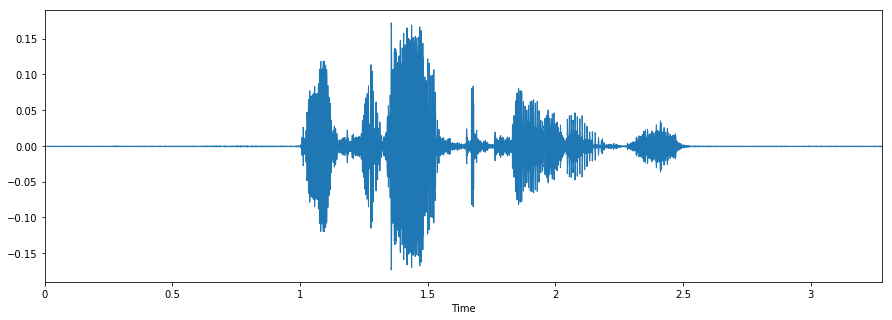

In [12]:
import librosa.display
plt.figure(figsize=(15, 5))
librosa.display.waveplot(y, sr=sr)

Note that there is nothing special about this graph except that the x-axis has been converted to time using our sample rate. If we plotted in matplotlib with plt.plot(y), we would get the same figure, but with sample number on the x-axis instead of seconds.

Amplitude and magnitude are often confused, but the difference is simple. Amplitude of a wave is just the distance, positive or negative, from the equilibrium (zero in our case), and magnitude is the absolute value of the amplitude. In audio we sample the amplitude. 

## Frequency and Pitch

Most of us remember frequency from physics as cycles per second of a wave. It's the same for sound, but really hard to see in the above image. How many cycles are there? How can there be cycles if it's not regular? The reality is that sound is extremely complex, and the above recording of human speech is the combination of many different frequencies added together. To talk about frequency and pitch, it's easier to start with a pure tone, so let's make one. 

Human hearing ranges from 20hz to 20,000hz, hz=hertz=cycles per second. The higher the frequency, the more cycles per second, and the "higher" the pitch sounds to us. To demonstrate, let's make a sound at 500hz, and another at 5000hz. 

In [13]:
# Adapted from https://musicinformationretrieval.com/audio_representation.html
# An amazing open-source resource, especially if music is your sub-domain.
def make_tone(freq, clip_length=1, sr=16000):
    t = np.linspace(0, clip_length, int(clip_length*sr), endpoint=False)
    return 0.1*np.sin(2*np.pi*freq*t)
clip_500hz = make_tone(500)
clip_5000hz = make_tone(5000)

In [14]:
Audio(clip_500hz, rate=sr)

In [15]:
Audio(clip_5000hz, rate=sr)

500 cycles per second, 16000 samples per second, means 1 cycle = 16000/500 = 32 samples, let's see 2 cycles

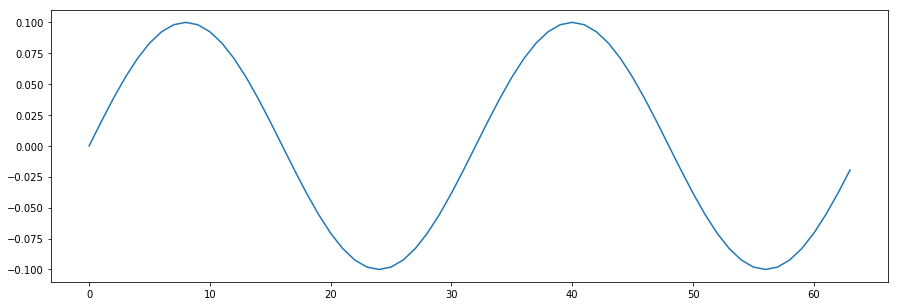

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(clip_500hz[0:64])

5000hz from the same vantage point, this is what is meant by higher frequency. Of course in real life this is a continuous wave, but since our digital representation is discrete, capturing it starts to break down for high frequencies if we don't increase our sample rate. The limitations of digital representations of audio are laid out by Nyquist Theorem, which we discuss later.

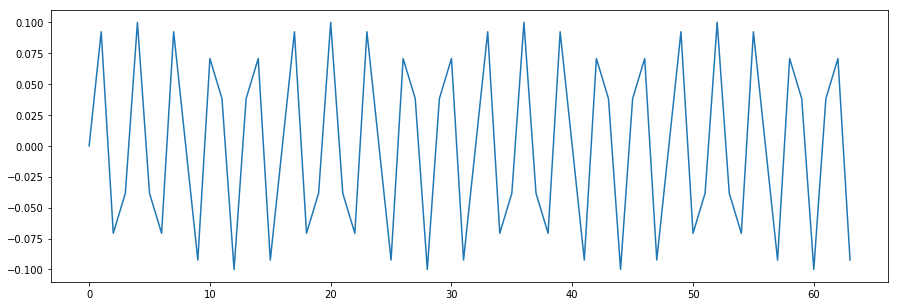

In [21]:
plt.figure(figsize=(15, 5))
plt.plot(clip_5000hz[0:64])

So if that's frequency, what is pitch? Pitch is a musical term that means the human perception of frequency, but is hugely important for machine learning because most of what we're interested in, speech, sound classification, music...etc are inseparable from human hearing and how it works. Let's do an experiment and increase the frequency of the above tones by 500hz each and see how much this moves our perception of them

In [22]:
clip_500_to_1000 = np.concatenate([make_tone(500), make_tone(1000)])
clip_5000_to_5500 = np.concatenate([make_tone(5000), make_tone(5500)])

In [23]:
# first half of the clip is 500hz, 2nd is 1000hz
Audio(clip_500_to_1000, rate=sr)

In [24]:
# first half of the clip is 5000hz, 2nd is 5500hz
Audio(clip_5000_to_5500, rate=sr)

Notice that the pitch of the first clip seems to change more even though they were shifted by the same amount. This makes intuitive sense as the frequency of the first was doubled and the frequency of the second only increased 10%. Like other forms of human perception, hearing is not linear, it is logarithmic. This will be important later as the range of frequencies from 100-200hz convey as much information to us as the range from 10,000-20,000hz. If we don't account for this in our data's representation, the lower frequency info will be squished out of existence. 

Fortunately, scientists have thought about this problem and came up with something called the mel scale.

## Mel scale

The mel scale is a human-centered metric of audio perception that was developed by asking participants to judge how far apart different tones were. Here is a formula from mel-scale's wikipedia page that you will never need, but might like to see.

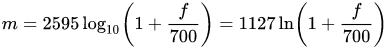

And here is a table of values that represent some examples of frequency in hz and their corresponding mel values. Note: Someone please tell me how to make this table horizontal and maintain the headers :)

| Frequency | Mel Equivalent |
| --- | --- |
| 20 | 0 |
| 160 | 250 |
| 394 | 500 |
| 670 | 750 |
| 1000 | 1000 |
| 1420 | 1250 |
| 1900 | 1500 |
| 2450 | 1750 |
| 3120 | 2000 |
| 4000 | 2250 |
| 5100 | 2500 |
| 6600 | 2750 |
| 9000 | 3000 |
| 14000 | 3250 |

When we visually represent audio using spectrograms, we will use the mel scale instead of frequency on our y-axis, so that our data is reshaped to mirror human perception. **If you're getting bored, hang in there, because we are so close to the fun part (spectrograms)**, but there is one last piece to human hearing puzzle we need to deal with.


## Decibels

Just like frequency, human perception of loudness occurs on a logarithmic scale. A constant increase in the amplitude of a wave will be perceived differently if the original sound is soft or loud. 

Decibels measure the ratio of power between 2 sounds, with the main idea being that each 10x increase in the energy of the wave (multiplicative) results in a 10dB increase in sound (additive). Thus something that is 20dB louder has 100x (10*10) the amount of energy, something that is 25dB louder has (10^2.5) = 316.23x more energy. 

The lowest audible sound, near absolute silence, is 0dB and we refer to other sounds based on how many times more energy they have than a 0dB sound. A dishwasher is ~30dB, or 10^3 = 1000x louder. Here is a nice chart taken from: https://boomspeaker.com/noise-level-chart-db-level-chart/

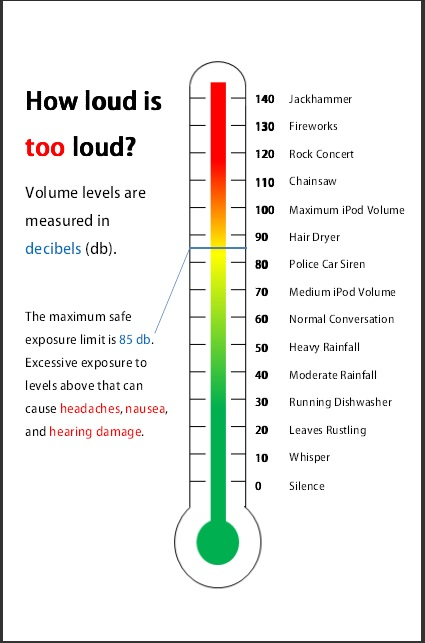

The range of human perception is vast, from a base of 0dB up to 100dB (an amount that will damage your hearing), is a range of 10^10, or 10,000,000,000x. A doubling of energy will only increase the dB level by ~3dB. If we don't use a logarithmic scale, we would squish whispers and rustling leaves, and even normal conversation out of existence. Thus is it is important that we measure our spectrograms be on the decibel scale for most of our applications. 

Deep dive for decibel scale: http://www.animations.physics.unsw.edu.au/jw/dB.htm

## Spectrogram as a visual representation of audio

Remember how it was impossible to see the smooth cycles and frequencies in the raw waveform graph of our first audio clip? A spectrogram is an almost magical way of breaking a complex signal apart into it's constituent frequencies, and then representing that as an image. Before we get into how this actually happens, let's see what they look like and how to generate and play with them, because this is more important for training your models than actually understanding what a fourier transform is and how it works. 

Librosa allows us to generate a spectrogram with the melscale directly using `librosa.feature.melspectrogram`. To demonstrate why the previous discussion of melscale and decibels was necessary, we'll first display a raw power spectrogram, then a melspectrogram, and then finally a melspectrogram on the decibel scale. 

sg = spectrogram, this is a raw energy spectrogram. stft = short-time fourier transform. stft returns a complex result with a real component, the magnitude, and a complex part, the phase. The complex part is typically not used in machine learning applications, but there are a few papers that suggest it is useful. For now we will discard it.

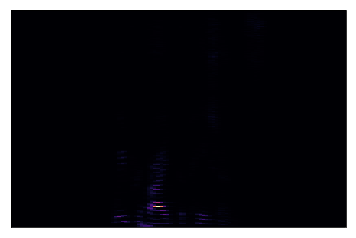

In [59]:
sg0 = librosa.stft(y)
sg_mag, sg_phase = librosa.magphase(sg0)
display(librosa.display.specshow(sg_mag))

Next we use the mel-scale instead of raw frequency. `librosa.feature.melspectrogram` can take either a raw spectrogram and convert to mel-scale, or a raw signal, compute the spectrogram, and then convert. We will use what we generated in the above cell

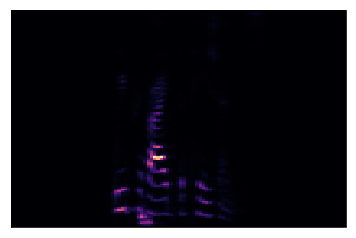

In [60]:
sg1 = librosa.feature.melspectrogram(S=sg_mag)
display(librosa.display.specshow(sg1))

It's a little better, but most of the information is still zeros, and the signal is full of info, so we are throwing away too much. Converting to the decibel scale using `librosa.amplitude_to_db` will fix this.

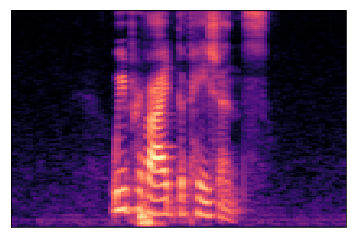

In [100]:
sg2 = librosa.amplitude_to_db(sg1, ref=np.min)
librosa.display.specshow(sg2)

Okay, this is starting to look like reasonable. But what does any of this mean? In the next section, we'll add on some axes and a colorbar legend and then look at the underlying data structure and see what we're dealing with

## What's inside a spectrogram

Text(0.5, 1.0, 'Mel spectrogram')

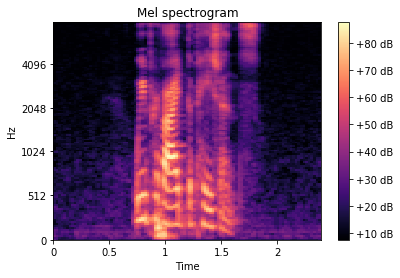

In [101]:
# code adapted from the librosa.feature.melspectrogram documentation
librosa.display.specshow(sg2, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')

Now we can see, just like when we plotted the audio, the x-axis is time, but now, instead of the amplitude of the wave on the y-axis, we have the frequency. The y-axis is also no longer linear, each new tick doubles the frequency, with a max frequency, or fmax of 8000. Also, this isn't a line graph like the raw waveform, instead of a single value at each timepoint on our x-axis, we have many. Every point in the square represents the energy at the **frequency of it's y-coordinate at the time of it's x-coordinate**. 

Take the point 1 second in at 1024hz, it appears to be cream colored meaning the energy at that point is somewhere around 80-85db. Meanwhile at that same time, 4096hz appears to be purple and have about 40dB of energy. That means that at t = 1 second, the sound with 1024hz is around 10000 times louder than sound at 4096hz. 10^((80-40)/10) = 10^4 = 10000.

Let's check out the min, max, and mean of the spectrogram. Remember, the units for these are all decibels. 

In [107]:
sg2.min(), sg2.max(), sg2.mean()

(7.564735729088099, 87.5647357290881, 26.085044085785125)

So it looks like spectrograms have a built in min, mean, and max, that's nice. Let's see what type of object a spectrogram really is so we can see what else we can do.

In [128]:
print(type(sg2))
sg2.shape

<class 'numpy.ndarray'>


(128, 103)

Spectrograms become a lot less magical and a lot easier to work with when you realize they're just 2d numpy arrays. We no longer have to remember and call random functions like librosa.display.specshow, with a little tinkering (converting to pytorch, and adding a unit axis) we can just use fastai's `Image()`

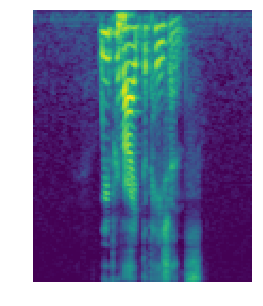

In [140]:
Image.show(torch.from_numpy(sg2).unsqueeze(0), figsize=(15, 5), cmap=None)

`unsqueeze(0)` adds a single axis in pos 0 so we go from 128x103 to 1x128x103. Images in fastai have 3 dimensions, the 
first, a channel dimension 1 for monochrome images, 3 for rgb. This is really black and white data but the `cmap` (colormap)
param displays it to us with color. In `Image.show` it defaults to None, but lower down fastai uses a default colormap
called 'viridis'. Try changing cmap to 'binary', or 'rainbow' or try an option that doesn't exist and matplotlib will give
you an options list in the error message.

## Spectrogram parameters and how to fine tune them for deep learning

Remember those hyperparameters mentioned in the intro? Our experiments indicate they matter a lot. If you don't understand your underlying data, you won't be able to create good visual representations of them. In fastai audio, we do our best to give you good default values, but to get the highest accuracy possible out of your models, you'll need to be able to tune it to your exact needs. Let's tune this one and introduce these parameters in the process.

Here's the same spectrogram, but with explicit default arguments. 